# **Point Net - Classification**

In this notebook, we will use the classification version of point net to classify objects from the shapenet dataset

In [1]:
import os
import sys
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.functional import kl_div


import open3d as o3


import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, fps, global_max_pool, radius
from torch_geometric.nn.conv import PointConv

#from open3d.web_visualizer import draw # for non Colab

sys.path.append('../src')

from models.utils import PointsTo3DShape
from models.PointNetEncoder import PointNetBackbone
from models.point_net_loss import ChamferDistanceLoss
from models.PointCloudEncoder import PointCloudEncoder
from models.PointCloudDecoder import PointCloudDecoder
from models.AutoEncoder import AutoEncoder
from models.VAE import VAE

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
print('MPS is build: {}'.format(torch.backends.mps.is_built()))
print('MPS Availability: {}'.format(torch.backends.mps.is_available()))
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device is set to :{}'.format(DEVICE))
#torch.set_default_device(DEVICE)
torch.seed = 42

MPS is build: True
MPS Availability: True
Device is set to :mps


### Get the data

In [4]:
# General parameters
#NUM_TRAIN_POINTS = 8192
NUM_TEST_POINTS = 2048

NUM_POINTS = 1024
NUM_CLASSES = 16

# model hyperparameters
GLOBAL_FEATS = 1024
BATCH_SIZE = 32

EPOCHS = 1000
LR = 0.0001
REG_WEIGHT = 0.001 

LATENT_DIM = 32

Helpers for our dataset

In [5]:
# get class - label mappings
CATEGORIES = {
    'Bathtub': 0,
    'Bed': 1,
    'Chair': 2,
    'Desk': 3,
    'Dresser': 4,
    'Monitor': 5,
    'Night_Stand': 6,
    'Sofa': 7,
    'Table': 8,
    'Toilet': 9,
}


In [6]:
#### MODELNET10 DATALOADER SETTING ####
modelnet_dataset_alias = "../data/ModelNet10"
pre_transform = T.NormalizeScale()


train_dataset = ModelNet(
    root=modelnet_dataset_alias,
    name=modelnet_dataset_alias[-2:],
    train=True,
    pre_transform=pre_transform,
    transform=T.SamplePoints(NUM_POINTS),
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_dataset = ModelNet(
    root=modelnet_dataset_alias,
    name=modelnet_dataset_alias[-2:],
    train=False,
    pre_transform=pre_transform,
    transform=T.SamplePoints(NUM_TEST_POINTS),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [7]:
points = next(iter(train_loader))[0].pos
PointsTo3DShape(points)
    

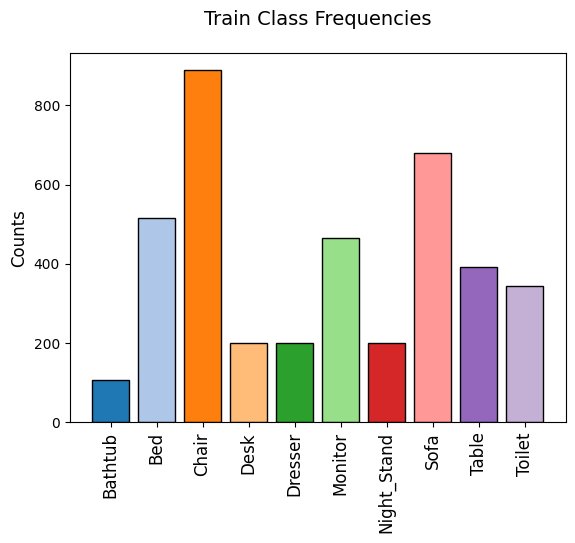

In [8]:
total_train_targets = []
for loader in train_loader:
    pos = loader.pos
    targets = loader.y
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=mpl.cm.tab20(np.arange(0, NUM_CLASSES)),
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20);

In [9]:
def VisualizeEmbedding(embedding):
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(8, 6))

    # Generate a 2D tensor
    tensor = embedding


    # Create a figure object with custom size

    # Plot the heatmap using Seaborn
    sns.heatmap(tensor, cmap='coolwarm', cbar=True)
    plt.title('Tensor Heatmap')

    plt.show()

We want to be sure we are not misclassifying or only focusing on easy or abundant examples. So we use the Matthews Correlation Coefficient to measure our models performance.

### Conditional Variational AutoEncoder Architecture

In [10]:
#encoder = PointCloudEncoder(latent_dim=LATENT_DIM, num_point=NUM_POINTS).to(DEVICE)
encoder = PointNetBackbone(num_points=NUM_POINTS, num_global_feats=LATENT_DIM, local_feat=False).to(DEVICE)
decoder = PointCloudDecoder(latent_dim=LATENT_DIM, num_hidden=3, num_point=NUM_POINTS).to(DEVICE)
autoencoder = AutoEncoder(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)
vae = VAE(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)

In [11]:
points = next(iter(train_loader)).pos
points.shape

torch.Size([32768, 3])

In [12]:
#norm_points = torch.stack([next(iter(train_loader))[idx].pos for idx in range(BATCH_SIZE)]).unsqueeze(1)
norm_points = torch.stack([next(iter(train_loader))[idx].pos for idx in range(BATCH_SIZE)]).transpose(2, 1)
norm_points.shape

torch.Size([32, 3, 1024])

In [ ]:

#v2 = f1.view(f1.size(0), -1, 1, 2)

norm_points = norm_points.to(DEVICE)
f1, _, _ = encoder(norm_points)
f1 = f1.cpu()
mu = nn.Linear(LATENT_DIM, LATENT_DIM)(f1)
logvar = nn.Linear(LATENT_DIM, LATENT_DIM)(f1)
print(mu.shape)

std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std
print(z.shape)

In [ ]:
def kl_normal(qm,qv,pm,pv):
    # tensor shape (Batch,dim)
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

def sample_gaussian(m, v, device):
    epsilon = torch.normal(torch.zeros(m.size()),torch.ones(m.size())).to(device)
    z = m + torch.sqrt(v) * epsilon
    return z

z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
z_prior = (z_prior_m, z_prior_v)

p_m = z_prior[0].expand(mu.size())
p_v = z_prior[1].expand(logvar.size())
kl_loss = kl_normal(mu,logvar,p_m,p_v)

sample_gaussian(mu,logvar,torch.device('cpu'))

In [ ]:
z.view(z.size(0), -1, 1, 1).shape

In [ ]:
z = z.view(BATCH_SIZE, LATENT_DIM, 1)
z.shape
d1 = nn.ConvTranspose1d(LATENT_DIM, LATENT_DIM, kernel_size=3, stride=3, padding=1)(z)
print(d1.shape)
d1 = nn.ConvTranspose1d(LATENT_DIM, LATENT_DIM*2, kernel_size=3, stride=3, padding=1)(d1)
print(d1.shape)
d1 = nn.ConvTranspose1d(LATENT_DIM*2, LATENT_DIM*4, kernel_size=3, stride=3, padding=1)(d1)
print(d1.shape)
d1 = nn.ConvTranspose1d(LATENT_DIM*4, LATENT_DIM*8, kernel_size=3, stride=3, padding=1)(d1)
print(d1.shape)
d1 = nn.ConvTranspose1d(LATENT_DIM*8, LATENT_DIM*16, kernel_size=3, stride=3, padding=1)(d1)
print(d1.shape)
d1 = nn.ConvTranspose1d(LATENT_DIM*16, LATENT_DIM*32, kernel_size=3, stride=3, padding=1)(d1)
print(d1.shape)
d1 = nn.ConvTranspose1d(LATENT_DIM*32, LATENT_DIM*32, kernel_size=3, stride=3, padding=0)(d1)
print(d1.shape)

In [ ]:
VisualizeEmbedding(d1[0].detach().numpy())

In [ ]:
d1 = nn.ConvTranspose2d(int(LATENT_DIM), int(LATENT_DIM*4), kernel_size=(3, 3), stride=(2, 2), padding=0)(d1)
print(d1.shape)
d1 = nn.ConvTranspose2d(int(LATENT_DIM*4), int(LATENT_DIM*8), kernel_size=(3, 3), stride=(2, 2), padding=0)(d1)
print(d1.shape)
d1 = nn.ConvTranspose2d(int(LATENT_DIM*8), 512, kernel_size=(3, 3), stride=(2, 2), padding=0)(d1)
print(d1.shape)
d1 =  nn.ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1), padding=0)(d1)
print(d1.shape)
#d3 = nn.ConvTranspose2d(256, 256, kernel_size=(4, 5), stride=(2, 3), padding=0)(d2)
#print(d3.shape)
#d4 = nn.ConvTranspose2d(256, 128, kernel_size=(5, 7), stride=(3, 3), padding=0)(d3)
#print(d4.shape)
d5 = nn.ConvTranspose2d(512, 3, kernel_size=(1, 1), stride=(1, 1), padding=0)(d1)
print(d5.shape)
v3 = d5.view(d5.size(0), -1, 3)
print(v3.shape)

In [ ]:
decoder(z.to(DEVICE)).shape

In [13]:
norm_points = norm_points.to(DEVICE)

#autoencoder(norm_points).shape
vae(norm_points)[0].shape

torch.Size([32, 1024, 3])

In [14]:
vae

VAE(
  (encoder): PointNetBackbone(
    (tnet1): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (linear1): Linear(in_features=1024, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (linear3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pool): MaxPool1d(kernel_size=1024, stride=1024, padding=0, dilation=1

In [ ]:
### Freeze the layers ###
#freeze_layer_list = ['conv1', 'conv2', 'conv3', 'pool1', 'pool2', 'conv4', 'conv5']
freeze_layer_list = ['encoder.tnet1.conv1.weight'
,'encoder.tnet1.conv1.bias'
,'encoder.tnet1.conv2.weight'
,'encoder.tnet1.conv2.bias'
,'encoder.tnet1.conv3.weight'
,'encoder.tnet1.conv3.bias'
,'encoder.tnet1.linear1.weight'
,'encoder.tnet1.linear1.bias'
,'encoder.tnet1.linear2.weight'
,'encoder.tnet1.linear2.bias'
,'encoder.tnet1.linear3.weight'
,'encoder.tnet1.linear3.bias'
,'encoder.tnet1.bn1.weight'
,'encoder.tnet1.bn1.bias'
,'encoder.tnet1.bn2.weight'
,'encoder.tnet1.bn2.bias'
,'encoder.tnet1.bn3.weight'
,'encoder.tnet1.bn3.bias'
,'encoder.tnet1.bn4.weight'
,'encoder.tnet1.bn4.bias'
,'encoder.tnet1.bn5.weight'
,'encoder.tnet1.bn5.bias'
,'encoder.tnet2.conv1.weight'
,'encoder.tnet2.conv1.bias'
,'encoder.tnet2.conv2.weight'
,'encoder.tnet2.conv2.bias'
,'encoder.tnet2.conv3.weight'
,'encoder.tnet2.conv3.bias'
,'encoder.tnet2.linear1.weight'
,'encoder.tnet2.linear1.bias'
,'encoder.tnet2.linear2.weight'
,'encoder.tnet2.linear2.bias'
,'encoder.tnet2.linear3.weight'
,'encoder.tnet2.linear3.bias'
,'encoder.tnet2.bn1.weight'
,'encoder.tnet2.bn1.bias'
,'encoder.tnet2.bn2.weight'
,'encoder.tnet2.bn2.bias'
,'encoder.tnet2.bn3.weight'
,'encoder.tnet2.bn3.bias'
,'encoder.tnet2.bn4.weight'
,'encoder.tnet2.bn4.bias'
,'encoder.tnet2.bn5.weight'
,'encoder.tnet2.bn5.bias'
,'encoder.conv1.weight'
,'encoder.conv1.bias'
,'encoder.conv2.weight'
,'encoder.conv2.bias'
,'encoder.conv3.weight'
,'encoder.conv3.bias'
,'encoder.conv4.weight'
,'encoder.conv4.bias'
,'encoder.conv5.weight'
,'encoder.conv5.bias'
,'encoder.bn1.weight'
,'encoder.bn1.bias'
,'encoder.bn2.weight'
,'encoder.bn2.bias'
,'encoder.bn3.weight'
,'encoder.bn3.bias'
,'encoder.bn4.weight'
,'encoder.bn4.bias'
,'encoder.bn5.weight'
,'encoder.bn5.bias'
,'fc_mu.weight'
,'fc_mu.bias'
,'fc_logvar.weight'
,'fc_logvar.bias']

for name, param in vae.named_parameters():
    if name in freeze_layer_list:
        param.requires_grad = False

for name, param in vae.named_parameters():
    if not param.requires_grad:
        print(f'Frozen Layer: {name}')

In [ ]:
#MODEL_PATH = '../models/trained/vae_pointnet_runs/run_autoencoder_0579/cls_model_126_0.057831637397408486.pth'
#autoencoder.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
autoencoder.train()


In [15]:
#vae = VAE(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)
#MODEL_PATH = '../models/trained/vae_pointnet_runs/cls_model_121_1.2107149896621705.pth'
#vae.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
vae.train()

VAE(
  (encoder): PointNetBackbone(
    (tnet1): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (linear1): Linear(in_features=1024, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (linear3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pool): MaxPool1d(kernel_size=1024, stride=1024, padding=0, dilation=1

In [ ]:
for name, param in vae.named_parameters():
    if param.requires_grad:
        print(f'Not Frozen Layer: {name}')

In [16]:
# Define the loss function and optimizer
num_batch = len(train_loader)
best_metric=99999999999


chamfer_loss = ChamferDistanceLoss().to(DEVICE)
#optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
optimizer = optim.Adam(vae.parameters(), lr=0.001, weight_decay=0.0001)

#optimizer = optim.SGD(autoencoder.parameters(), lr=0.0001)

In [17]:
# Training loop (you will need to load your point cloud dataset and preprocess it)
for epoch in range(EPOCHS):
    _loss = []
    _rc_loss = []
    _kl_loss = []
    for i, data in tqdm(enumerate(train_loader)):  # Iterate through your dataset
        optimizer.zero_grad()
        
        # Forward pass
        batch_size = data.y.shape[0]
        #points = torch.stack([data[idx].pos for idx in range(batch_size)]).unsqueeze(1) ## If Convolution Encoder

        points = torch.stack([data[idx].pos for idx in range(batch_size)]).transpose(2, 1) ## If PointNet Encoder
        targets = data.y
        
        points = points.to(DEVICE)
        targets = targets.to(DEVICE)



        #reconstructed_x = autoencoder(points)
        
        reconstructed_x, mu, logvar = vae(points)
        
        # Compute the reconstruction loss
        loss_reconstruction = chamfer_loss(reconstructed_x, points.transpose(2, 1)) ## If PointNet Encoder is used
        #loss_reconstruction = chamfer_loss(reconstructed_x, points.squeeze(1))
        #kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        # Total loss is a combination of reconstruction loss and KL divergence loss

        #loss = loss_reconstruction
        loss = loss_reconstruction + kl_divergence

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        #if i % 50 == 0:
        #    print('{}: {}/{} - loss: {} - KL Loss: {} - Reconst Loss: {}'.format(epoch, i, num_batch, loss.item(), kl_divergence.item(), loss_reconstruction.item()))
            #print('{}: {}/{} - loss: {}'.format(epoch, i, num_batch, loss.item()))

        _loss.append(loss.item())
        _rc_loss.append(loss_reconstruction.item())
        _kl_loss.append(kl_divergence.item())
    
    epoch_loss = np.mean(_loss)
    rc_loss = np.mean(_rc_loss)
    kl_loss = np.mean(_kl_loss)

    #print(f'Epoch: {epoch} - Loss: {epoch_loss:.4f} ')
    print('Epoch: {} - Loss: {} - Reconst Loss: {} - KL Loss: {}'.format(epoch, epoch_loss, rc_loss, kl_loss))
    torch.save(vae.state_dict(), '../models/trained/vae_pointnet_runs/cls_model_{}_{}.pth'.format(epoch, epoch_loss))
    #torch.save(autoencoder.state_dict(), '../models/trained/vae_pointnet_runs/cls_model_{}_{}.pth'.format(epoch, epoch_loss))

125it [01:35,  1.31it/s]


Epoch: 0 - Loss: 0.9497417404651641 - Reconst Loss: 0.14376031643152237 - KL Loss: 0.8059814260005951


125it [01:37,  1.28it/s]


Epoch: 1 - Loss: 0.17005829608440398 - Reconst Loss: 0.1260525090098381 - KL Loss: 0.04400578685104847


125it [01:33,  1.34it/s]


Epoch: 2 - Loss: 0.14562660813331604 - Reconst Loss: 0.12638111859560014 - KL Loss: 0.019245489403605463


125it [01:33,  1.34it/s]


Epoch: 3 - Loss: 0.13906712675094604 - Reconst Loss: 0.12621729785203933 - KL Loss: 0.012849829159677029


125it [01:35,  1.31it/s]


Epoch: 4 - Loss: 0.1345909622311592 - Reconst Loss: 0.12617620170116425 - KL Loss: 0.008414760407060384


46it [00:40,  1.01it/s]

In [ ]:
MODEL_PATH = '../models/trained/vae_pointnet_runs/autoencoder_run1_06/cls_model_60_0.06183072060346603.pth'

#vae.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
#vae.eval()

autoencoder.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
autoencoder.eval()


In [ ]:
from random import randrange

torch.cuda.empty_cache() # release GPU memory

# get random sample from test data 
random_idx = randrange(len(train_dataset))
print('Index: {}'.format(random_idx))
points, targets = train_dataset[random_idx].pos, train_dataset[random_idx].y
print(points.shape)


vae.eval()

with torch.no_grad():
    #norm_points = points.unsqueeze(0).transpose(2, 1).to(DEVICE)
    #norm_points = points.unsqueeze(0).unsqueeze(1).to(DEVICE) ## If Convolution Encoder
    norm_points = points.unsqueeze(0).transpose(2, 1).to(DEVICE) ## If PointNet Encoder
    print(norm_points.shape)

    targets = targets.squeeze().to(DEVICE)
    
    reconstructed_x, mu, logvar = vae(norm_points)
    #reconstructed_x = autoencoder(norm_points)

chamfer_loss(reconstructed_x.to(DEVICE), points.unsqueeze(1).to(DEVICE))

In [ ]:
PointsTo3DShape(points.cpu().numpy())


In [ ]:
PointsTo3DShape(reconstructed_x.squeeze(0).cpu().numpy())


In [ ]:
reconstructed_x = reconstructed_x.to(DEVICE)
reconstructed_x

In [ ]:
points = points.to(DEVICE)
points

In [ ]:
PointsTo3DShape(((reconstructed_x - points.unsqueeze(0).transpose(2, 1)) ** 2).transpose(2, 1).squeeze(0).cpu().numpy())

In [ ]:
criterion = nn.MSELoss().to(DEVICE)
criterion(reconstructed_x ,points.unsqueeze(0).transpose(2, 1))